In [33]:
import pandas as pd
import numpy as np
import ast
from sklearn.feature_extraction.text import CountVectorizer
import nltk # I want to change run, running, ran to run, run, run
from sklearn.metrics.pairwise import cosine_similarity
import os
import seaborn as sns

In [34]:
# Data Preprocessing

def convert(obj):
    L = []
    for i in ast.literal_eval(obj):
        L.append(i['name'])
    return L

def convert3(obj):
    L = []
    counter = 0
    for i in ast.literal_eval(obj):
        if counter != 3:
            L.append(i['name'])
            counter+=1
        else:
            break
            
    return L

def fetch_director(obj):
    L = []
    for i in ast.literal_eval(obj):
        if i['job'] == 'Director':
            L.append(i['name'])
            break
    return L


movies = pd.read_csv("tmdb_5000_movies.csv")
credits = pd.read_csv("tmdb_5000_credits.csv")
file_size = os.path.getsize("tmdb_5000_credits.csv")/1000000
file_size1 = os.path.getsize("tmdb_5000_credits.csv")/1000000
movies = movies.merge(credits,on='title')
movies = movies[['movie_id','title','overview','genres','keywords','cast','crew']]
movies.isnull().sum()
movies.dropna(inplace=True)
movies.duplicated().sum()
movies['genres'] = movies['genres'].apply(convert)
movies['keywords'] = movies['keywords'].apply(convert)
movies['cast'] =movies['cast'].apply(convert3)
movies['crew'] = movies['crew'].apply(fetch_director)
movies['overview'] = movies['overview'].apply(lambda x:x.split())
movies['genres'] = movies['genres'].apply(lambda x:[i.replace(" ","") for i in x])
movies['keywords'] = movies['keywords'].apply(lambda x:[i.replace(" ","") for i in x])
movies['cast'] = movies['cast'].apply(lambda x:[i.replace(" ","") for i in x])
movies['crew'] = movies['crew'].apply(lambda x:[i.replace(" ","") for i in x])
movies['tags'] = movies['overview'] + movies['genres']+movies['keywords'] + movies['cast']+movies['crew']
movies.head()

,movie_id,title,overview,genres,keywords,cast,crew,tags
0,19995,Avatar,"[In, the, 22nd, century,, a, paraplegic, Marin...","[Action, Adventure, Fantasy, ScienceFiction]","[cultureclash, future, spacewar, spacecolony, ...","[SamWorthington, ZoeSaldana, SigourneyWeaver]",[JamesCameron],"[In, the, 22nd, century,, a, paraplegic, Marin..."
1,285,Pirates of the Caribbean: At World's End,"[Captain, Barbossa,, long, believed, to, be, d...","[Adventure, Fantasy, Action]","[ocean, drugabuse, exoticisland, eastindiatrad...","[JohnnyDepp, OrlandoBloom, KeiraKnightley]",[GoreVerbinski],"[Captain, Barbossa,, long, believed, to, be, d..."
2,206647,Spectre,"[A, cryptic, message, from, Bond’s, past, send...","[Action, Adventure, Crime]","[spy, basedonnovel, secretagent, sequel, mi6, ...","[DanielCraig, ChristophWaltz, LéaSeydoux]",[SamMendes],"[A, cryptic, message, from, Bond’s, past, send..."
3,49026,The Dark Knight Rises,"[Following, the, death, of, District, Attorney...","[Action, Crime, Drama, Thriller]","[dccomics, crimefighter, terrorist, secretiden...","[ChristianBale, MichaelCaine, GaryOldman]",[ChristopherNolan],"[Following, the, death, of, District, Attorney..."
4,49529,John Carter,"[John, Carter, is, a, war-weary,, former, mili...","[Action, Adventure, ScienceFiction]","[basedonnovel, mars, medallion, spacetravel, p...","[TaylorKitsch, LynnCollins, SamanthaMorton]",[AndrewStanton],"[John, Carter, is, a, war-weary,, former, mili..."


In [35]:
new_df = movies[['movie_id','title','tags']]
new_df['tags']=new_df['tags'].apply(lambda x: " ".join(x))
new_df['tags'] = new_df['tags'].apply(lambda x: x.lower())
new_df.head()

/var/folders/yl/4ccxtmhs3mz5h159wwwzjqyr0000gn/T/ipykernel_30965/3659737190.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['tags']=new_df['tags'].apply(lambda x: " ".join(x))
/var/folders/yl/4ccxtmhs3mz5h159wwwzjqyr0000gn/T/ipykernel_30965/3659737190.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['tags'] = new_df['tags'].apply(lambda x: x.lower())


,movie_id,title,tags
0,19995,Avatar,"in the 22nd century, a paraplegic marine is di..."
1,285,Pirates of the Caribbean: At World's End,"captain barbossa, long believed to be dead, ha..."
2,206647,Spectre,a cryptic message from bond’s past sends him o...
3,49026,The Dark Knight Rises,following the death of district attorney harve...
4,49529,John Carter,"john carter is a war-weary, former military ca..."


In [36]:
def stem(text):
    y = []
    for i in text.split():
        y.append(ps.stem(i))
    return " ".join(y)

cv = CountVectorizer(max_features=5000,stop_words='english')
vectors = cv.fit_transform(new_df['tags']).toarray()
from nltk.stem.porter import PorterStemmer
ps = PorterStemmer()
new_df.loc[:, 'tags'] = new_df['tags'].apply(stem)


In [37]:
cv.get_feature_names_out()
np.set_printoptions(linewidth=np.inf)
similarity = cosine_similarity(vectors)
def recommend(movies_to_check, top_n=5):
    movie_indices = [new_df[new_df['title'] == movie].index[0] for movie in movies_to_check]
    avg_similarity = np.mean(similarity[movie_indices], axis=0)
    for idx in movie_indices:
        avg_similarity[idx] = -1 
    top_indices = np.argsort(avg_similarity)[::-1][:top_n]
    print(f"Top {top_n} Recommendations based on selected movies:")
    for i in top_indices:
        print(f"Similarity Score: {avg_similarity[i]} - Movie Title: {new_df.iloc[i].title}")

recommend(['The Avengers', 'Avatar', 'Spectre','Iron Man 3'])

Top 5 Recommendations based on selected movies:
Similarity Score: 0.2675473451645187 - Movie Title: Avengers: Age of Ultron
Similarity Score: 0.23698646053517386 - Movie Title: Captain America: Civil War
Similarity Score: 0.2303310285790789 - Movie Title: Iron Man
Similarity Score: 0.22349570300707478 - Movie Title: Iron Man 2
Similarity Score: 0.19803634865966732 - Movie Title: Captain America: The First Avenger


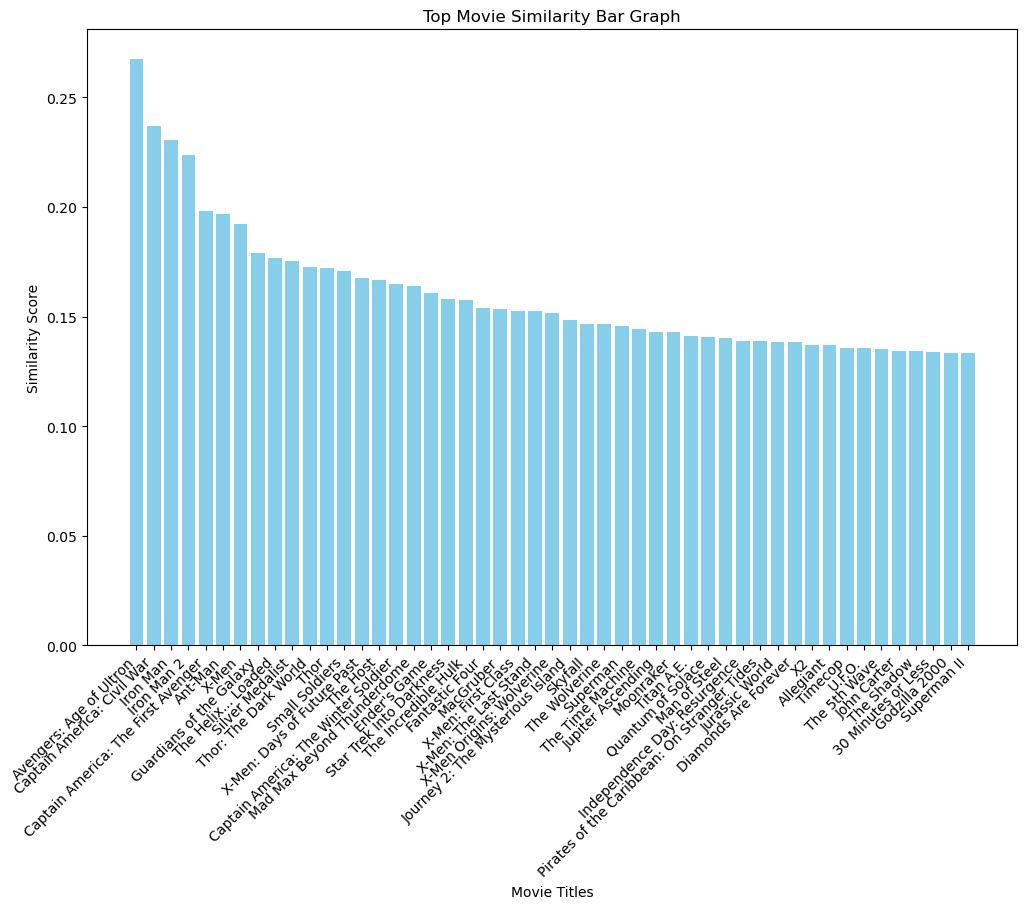

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns

def recommend_return (movies_to_check, top_n=5):
    movie_indices = [new_df[new_df['title'] == movie].index[0] for movie in movies_to_check]
    avg_similarity = np.mean(similarity[movie_indices], axis=0)
    for idx in movie_indices:
        avg_similarity[idx] = -1 
    top_indices = np.argsort(avg_similarity)[::-1][:top_n]
    recommendations = [(new_df.iloc[i].title, avg_similarity[i]) for i in top_indices]
    
    return recommendations

        
top_movie_recommendations = recommend_return(['The Avengers', 'Avatar', 'Spectre', 'Iron Man 3'], top_n=50)

movie_titles, similarity_scores = zip(*top_movie_recommendations)

fig, ax = plt.subplots(figsize=(12, 8))
plt.bar(movie_titles, similarity_scores, color='skyblue')
plt.xlabel('Movie Titles')
plt.ylabel('Similarity Score')
plt.title('Top Movie Similarity Bar Graph')
plt.xticks(rotation=45, ha='right') 
plt.show()

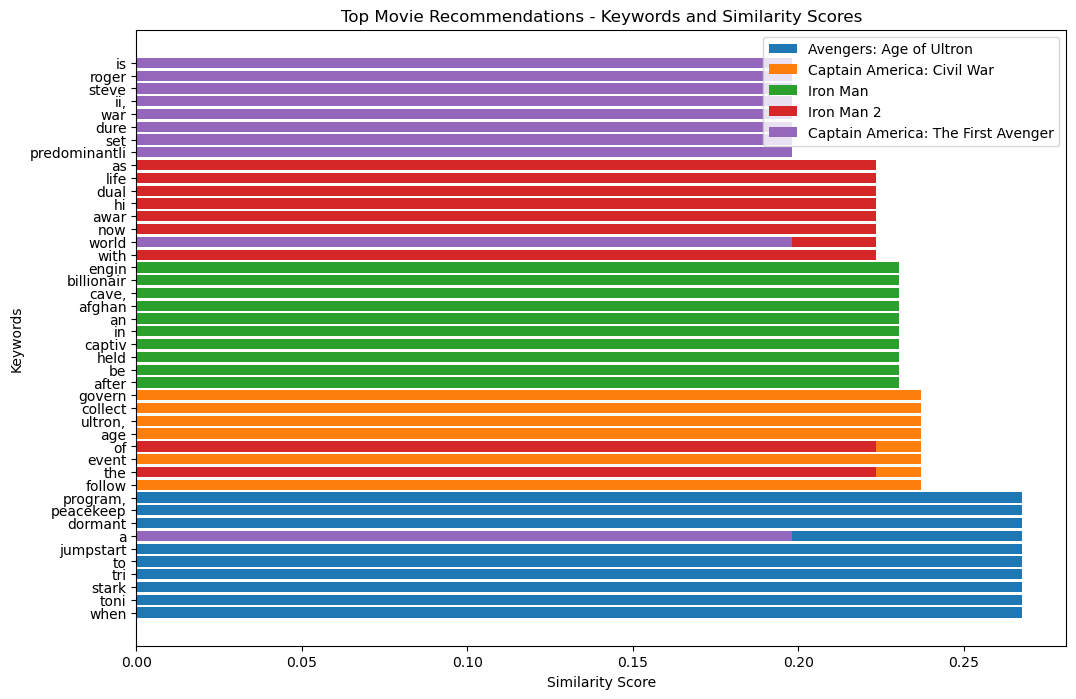

In [45]:

def recommend(movies_to_check, top_n=5, top_keywords_to_display=10):
    movie_indices = [new_df[new_df['title'] == movie].index[0] for movie in movies_to_check]
    avg_similarity = np.mean(similarity[movie_indices], axis=0)
    for idx in movie_indices:
        avg_similarity[idx] = -1 
    top_indices = np.argsort(avg_similarity)[::-1][:top_n]
    
    recommendations = []
    
    for i in top_indices:
        movie_title = new_df.iloc[i].title
        similarity_score = avg_similarity[i]
        keywords = new_df.iloc[i].tags.split()[:top_keywords_to_display]  
        recommendations.append((movie_title, similarity_score, keywords))
        
    return recommendations

top_movie_recommendations = recommend(['The Avengers', 'Avatar', 'Spectre', 'Iron Man 3'], top_n=5, top_keywords_to_display=10)

sns.reset_orig()

ffig, ax = plt.subplots(figsize=(12, 8))
for movie_title, similarity_score, keywords in top_movie_recommendations:
    ax.barh(keywords, [similarity_score] * len(keywords), label=movie_title)

ax.set_ylabel('Keywords')
ax.set_xlabel('Similarity Score')
ax.set_title('Top Movie Recommendations - Keywords and Similarity Scores')
ax.legend()
plt.show()

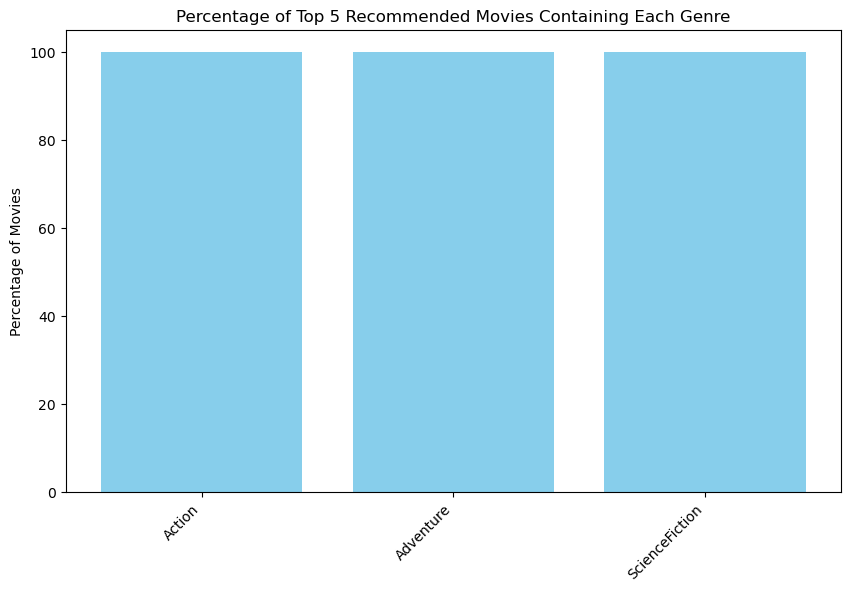

In [68]:
def recommend(movies_to_check, top_n=5):
    movie_indices = [new_df[new_df['title'] == movie].index[0] for movie in movies_to_check]
    avg_similarity = np.mean(similarity[movie_indices], axis=0)
    for idx in movie_indices:
        avg_similarity[idx] = -1 
    top_indices = np.argsort(avg_similarity)[::-1][:top_n]
    
    recommendations = []
    
    for i in top_indices:
        movie_title = new_df.iloc[i].title
        genres = movies.iloc[i].genres
        recommendations.append((movie_title, genres))
        
    return recommendations

original_movies = ['The Avengers', 'Avatar', 'Spectre', 'Iron Man 3']
top_movie_recommendations = recommend(original_movies, top_n=5)


genre_counts = {}
for _, genres in top_movie_recommendations:
    for genre in genres:
        genre_counts[genre] = genre_counts.get(genre, 0) + 1

total_recommendations = len(top_movie_recommendations)
genre_percentages = {genre: (count / total_recommendations) * 100 for genre, count in genre_counts.items()}


fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(genre_percentages.keys(), genre_percentages.values(), color='skyblue')
ax.set_ylabel('Percentage of Movies')
ax.set_title('Percentage of Top 5 Recommended Movies Containing Each Genre')
plt.xticks(rotation=45, ha='right')

plt.show()
